**tmpw0h7p9s5, equation 22**

Ablation study on the DYAMOND data -- setting parameters to 0 and re-tuning

--> Here in the physical form of the equation (I hope Nelder-Mead and BFGS won't fail because of that)

In [1]:
# Python 3 module

import os
import sys
import json
import numpy as np
import xarray as xr
import sympy as sp
import matplotlib.pyplot as plt

sys.path.insert(0, '~/workspace_icon-ml/symbolic_regression')
from functions import append_dict_to_json
from sklearn import tree

sys.path.insert(0, '~/workspace_icon-ml/cloud_cover_parameterization/')
import my_classes
from my_classes import load_data

SEED = int(sys.argv[1])
np.random.seed(SEED)

ValueError: invalid literal for int() with base 10: '-f'

### Load data

In [ ]:
order_of_vars = ['q', 'clwc', 'ciwc', 't', 'pa', 'zg', 'cc']
data_dict = load_data(source='era5', days='all', order_of_vars=order_of_vars)

TIMESTEPS, VLAYERS, HFIELDS = data_dict['q'].shape

# Removing four upper-most levels
for key in data_dict.keys():
    data_dict[key] = data_dict[key][:, 4:].copy()

# Data output
data_output = data_dict['cc']
del data_dict['cc']

for key in data_dict.keys():
    print(data_dict[key].shape)
    assert data_dict[key].shape == data_dict[key].shape

In [ ]:
import time
t0 = time.time()

# Add rh
T0 = 273.15
r = 0.00263*data_dict['pa']*data_dict['q']*np.exp((17.67*(data_dict['t']-T0))/(data_dict['t']-29.65))**(-1)
data_dict['rh'] = r

# Add rh_z
folder = 'rh_z'

# Initialize all_npy_files with empty tensor
all_npy_files = np.zeros((0, VLAYERS-4, HFIELDS))

# Load all filenames in the folder containing the derivatives. The filenames are sorted chronologically.
npy_file_names = sorted(os.listdir(os.path.join('~/bd1179_work/ERA5/hvcg_data', folder)))        

for file in npy_file_names:
    # Load three-hourly data and convert directly to float32
    npy_file = np.load('~/bd1179_work/ERA5/hvcg_data/%s/%s'%(folder,file), mmap_mode='r')
    npy_file = np.float32(npy_file[0::3].copy())
    all_npy_files = np.concatenate((all_npy_files, npy_file), axis=0)
data_dict[folder] = all_npy_files 

**Reshaping and keeping only the relevant features**

In [ ]:
# Keeping only the relevant features
features = ['rh', 't', 'clwc', 'ciwc', 'rh_z']
for key in features:
    data_dict[key] = np.reshape(data_dict[key], -1)
    
data_output = np.reshape(data_output, -1)

del data_dict['q']
del data_dict['pa']
del data_dict['zg']

no_features = len(data_dict.keys())

**Cast dict into ndarray**

In [6]:
# data_array = np.zeros((data_dict['q'].size, len(data_dict.keys())), dtype=np.float32)

k = 0
data_array_not_T = []
for key in features:
    print(key)
    data_array_not_T.append(np.reshape(data_dict[key], -1))
    del data_dict[key]
    k += 1

# Convert into np array and transpose
data_array = np.transpose(np.array(data_array_not_T, dtype=np.float32))

rh
t
clwc
ciwc
rh_z


In [7]:
# Update loc
loc = {}
for i in range(len(features)):
    loc[features[i]] = i

**Remove condensate-free cells**

In [8]:
# Already remove the regime with clw + cli = 0
reg_not_0 = np.where(data_array[:, loc['clwc']] + data_array[:, loc['ciwc']] > 1e-20)[0]
data_array = data_array[reg_not_0]
data_output = data_output[reg_not_0]

**Define the training/validation sets**

In [9]:
# Defines the training set
T_subset_train = 10**6
inds_train = np.random.randint(0, data_array.shape[0], T_subset_train)

flattened_input_train = data_array[inds_train]
flattened_output_train = data_output[inds_train]

# Defines the validation set
T_subset_valid = 10**6
inds_valid = np.random.randint(0, data_array.shape[0], T_subset_valid)

flattened_input_valid = data_array[inds_valid]
flattened_output_valid = data_output[inds_valid]

### Ablation Study

**Optimize coefficients in physical equation**

In [16]:
# See ~/workspace_icon-ml/symbolic_regression/finding_symmetries/pysr_results_dyamond_on_regimes/no_of_regimes_2/notes.txt
def func(X, a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,eps,A,B):
    rh = X[:, loc['rh']] 
    ta = X[:, loc['t']] 
    clw = X[:, loc['clwc']] 
    cli = X[:, loc['ciwc']]
    rh_z = X[:, loc['rh_z']]
    
    if np.abs(a_1) > 1e-5:
        rh = np.maximum(rh, -a_2/(2*a_1)*ta**2 + a_4/(2*a_1)*ta - a_5/(2*a_1))
    
    return a_1*rh**2+ta**2*(a_2*rh-a_3)-a_4*rh*ta+a_5*rh+a_6*ta-a_7 + (a_8*rh_z)**2*(A*rh_z+a_9) - B/(a_10*clw+a_11*cli+eps)

In [17]:
import scipy as sci
from scipy.optimize import minimize

In [18]:
def objective(P, X,Y,force_zero=None):
    '''
        The objective function.
    '''
    a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,eps,A,B = P
    
    # A way to remove terms using a list. Somehow I cannot use locals or exec here...
    if force_zero == 'a_1': a_1 = 0
    elif force_zero == 'a_2': a_2 = 0
    elif force_zero == 'a_3': a_3 = 0
    elif force_zero == 'a_4': a_4 = 0
    elif force_zero == 'a_5': a_5 = 0
    elif force_zero == 'a_6': a_6 = 0
    elif force_zero == 'a_7': a_7 = 0
    elif force_zero == 'a_8': a_8 = 0
    elif force_zero == 'a_9': a_9 = 0
    elif force_zero == 'a_10': a_10 = 0
    elif force_zero == 'a_11': a_11 = 0
    elif force_zero == 'eps': eps = 0
    elif force_zero == 'A': A = 0
    
    elif force_zero == 'I1': (a_1, a_2, a_3, a_4, a_5, a_6, a_7) = (0,0,0,0,0,0,0)
    elif force_zero == 'I2': (a_8,a_9, A) = (0,0,0)
    elif force_zero == 'I3': B = 0
            
    train_preds = np.minimum(np.maximum(func(X, a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,eps,A,B), 0), 100) 
    train_mse = np.mean((train_preds - Y)**2, dtype=np.float64)

    return train_mse

(a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,eps,A,B) = (203, 0.06588, 0.03969, 33.87, 4224.6, 18.9586, 2202.6, 146715, 0.00286, 8641, 32544, 0.0106, 1, 1)

**Evaluate reduced equations**

In [19]:
valid_mses = {}

In [20]:
parameters = [None,'a_1','a_2','a_3','a_4','a_5','a_6','a_7','a_8','a_9','a_10','a_11','A','I1','I2','I3']

for par_ind in range(len(parameters)):
    force_zero = parameters[par_ind]

    # Nelder-Mead gives me the same result
    res_bfgs = minimize(objective, (a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,eps,A,B), args=(flattened_input_train, flattened_output_train, force_zero), \
                   method='BFGS', options={'disp': True})

    res_nm = minimize(objective, (a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,eps,A,B), args=(flattened_input_train, flattened_output_train, force_zero), \
                   method='Nelder-Mead', options={'disp': True})

    # Compute objective for both minima
    valid_reg_mse_bfgs = objective(res_bfgs.x, flattened_input_valid, flattened_output_valid, force_zero)
    valid_reg_mse_nm = objective(res_nm.x, flattened_input_valid, flattened_output_valid, force_zero)

    valid_reg_mse = np.minimum(valid_reg_mse_bfgs, valid_reg_mse_nm)

    print('On the entire dataset')
    print('Valid MSE: %.5f'%valid_reg_mse)

    # Add to dictionary
    if force_zero == None:
        valid_mses['full_eq'] = valid_reg_mse
    else:      
        valid_mses[force_zero] = valid_reg_mse

Optimization terminated successfully.
         Current function value: 809.480532
         Iterations: 3
         Function evaluations: 144
         Gradient evaluations: 9
On the entire dataset
Valid MSE: 121.68441
         Current function value: 231.811586
         Iterations: 20
         Function evaluations: 2233
         Gradient evaluations: 139
On the entire dataset
Valid MSE: 127.65093
         Current function value: 809.488456
         Iterations: 13
         Function evaluations: 1516
         Gradient evaluations: 94
Optimization terminated successfully.
         Current function value: 809.488457
         Iterations: 325
         Function evaluations: 752
On the entire dataset
Valid MSE: 806.64425
         Current function value: 7922.863857
         Iterations: 1
         Function evaluations: 1276
         Gradient evaluations: 79
Optimization terminated successfully.
         Current function value: 7922.862974
         Iterations: 269
         Function evaluations: 70

/tmp/ipykernel_117100/386739602.py:9: RuntimeWarning: divide by zero encountered in divide
  return a_1*rh**2+ta**2*(a_2*rh-a_3)-a_4*rh*ta+a_5*rh+a_6*ta-a_7 + (a_8*rh_z+a_9)**2*(A*rh_z+a_10) - B/(a_11*clw+a_12*cli+eps)


         Current function value: 662.206660
         Iterations: 4
         Function evaluations: 1239
         Gradient evaluations: 77
On the entire dataset
Valid MSE: 126.96038
         Current function value: 276.865257
         Iterations: 14
         Function evaluations: 1243
         Gradient evaluations: 77
On the entire dataset
Valid MSE: 183.32516
Optimization terminated successfully.
         Current function value: 809.603272
         Iterations: 1
         Function evaluations: 48
         Gradient evaluations: 3
On the entire dataset
Valid MSE: 220.64548
Optimization terminated successfully.
         Current function value: 809.600825
         Iterations: 1
         Function evaluations: 64
         Gradient evaluations: 4
On the entire dataset
Valid MSE: 138.30798
Optimization terminated successfully.
         Current function value: 809.549725
         Iterations: 0
         Function evaluations: 16
         Gradient evaluations: 1
Optimization terminated successfully.

/tmp/ipykernel_117100/386739602.py:9: RuntimeWarning: invalid value encountered in divide
  return a_1*rh**2+ta**2*(a_2*rh-a_3)-a_4*rh*ta+a_5*rh+a_6*ta-a_7 + (a_8*rh_z+a_9)**2*(A*rh_z+a_10) - B/(a_11*clw+a_12*cli+eps)


On the entire dataset
Valid MSE: 252.05685


In [21]:
with open('~/workspace_icon-ml/symbolic_regression/evaluate_schemes/on_era5/results/ablation_study/ablation_study_phys_seed_%d.json'%SEED, 'w') as file:
    json.dump(valid_mses, file)

**Plot results**

In [22]:
with open('~/workspace_icon-ml/symbolic_regression/evaluate_schemes/on_era5/results/ablation_study/ablation_study_phys_seed_%d.json'%SEED, 'r') as file:
    valid_mses = json.load(file)

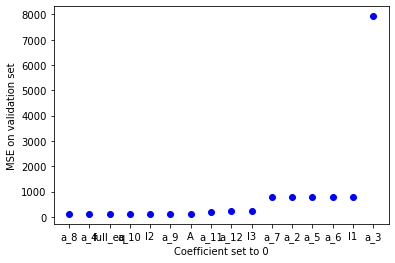

In [23]:
sorted_inds = np.argsort(list(valid_mses.values()))
plt.plot(np.delete(np.array(list(valid_mses.keys()))[sorted_inds], 4), np.delete(np.array(list(valid_mses.values()))[sorted_inds], 4), 'bo')
plt.ylabel('MSE on validation set')
plt.xlabel('Coefficient set to 0')
plt.savefig('~/workspace_icon-ml/symbolic_regression/evaluate_schemes/on_era5/results/ablation_study/ablation_study_phys_seed_%d.pdf'%SEED)

Text(0.5, 0, 'Coefficient set to 0')

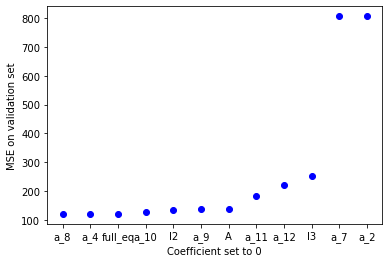

In [24]:
sorted_inds = np.argsort(list(valid_mses.values()))
plt.plot(np.delete(np.array(list(valid_mses.keys()))[sorted_inds], 4)[:-4], np.delete(np.array(list(valid_mses.values()))[sorted_inds], 4)[:-4], 'bo')
plt.ylabel('MSE on validation set')
plt.xlabel('Coefficient set to 0')